In [4]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from random import randint
from statsmodels.stats.power import tt_ind_solve_power

# Типы выборок, примеры генерации

1. Простая или случайная выборка. Самый популярный вид случайных выборок, используемый в A/B-тестах. Это попытка извлечь из генеральной совокупности выборку определенного размера рандомно. При достаточно больших размерах выборки случайность попадания в нее элементов из генеральной совокупности гарантирует репрезентативность.
2. Систематическая. Выбирается случайная начальная точка и интервал, через который происходит извлечение следующего наблюдения из генеральной совокупности в выборку. Данный тип случайной выборки является уязвимым к периодичности в списке.
3. Кластерная. Совокупность данных распределяется не по элементам, а по группам. Случайно отбираемой единицей здесь является не элемент, а именно группа.
4. Взвешенная. Не является строго пропорциональной к распределению классов в популяции. Некоторые классы могут считаться более важными и интересными. Результаты анализа по данному типу случайной выборки могут страдать от проблем внешней достоверности, когда потребуется перенести выводы на всю генеральную совокупность, но, с другой стороны, этот тип выборки дает возможность обнаружить инсайты по интересной для анализа группе.
5. Стратифицированная. Происходит деление популяции на отдельные подгруппы-страты по важным характеристикам с последующим случайным отбором элементов в каждой из подгрупп. В итоге получается хорошая представленность каждой страты в финальной объединенной выборке.

### Простая случайная выборка

#### np.random.choice()

Здесь можно использовать полезную функцию библиотеки numpy random.choice(), которая берет на вход массив и возвращает выборку нужного размера.

Напишем функцию, которая принимает на вход массив и формирует случайную выборку из n-элементов при помощи random.choice из библиотеки numpy:

In [ ]:
np.random.seed(4)
# генерация совокупности данных, подчиняющихся нормальному распределению
N = 100000 # совокупность данных на примере 10 тыс.значений
mu = 10   # среднее совокупности
std = 2   # среднеквадратичное отклонение

#генерируем 10000 нормально распределенный случайных величин из распределения с заданными параметрами
population_data = np.random.normal(mu, std, N)

# задаем размер требуемой случайной выборки
n = 100

# функция, которая которая формирует случайную выборку из n-элементов
def random_sampling(array, n):
    random_sample = np.random.choice(array, replace = False, size = n) # replace = True, если требуется выборка с возвратом
    return(random_sample)
np.random.seed(1) # важно не забывать про seed, чтобы результаты деления были воспроизводимы
random_sample = random_sampling(population_data, n)
random_sample

array([10.38619206,  7.38599531,  7.64656447,  8.74616764,  9.77133774,
       10.43216963, 10.27442803,  8.08073798,  9.50418917, 11.11870389,
       10.01156568,  8.38206823,  6.78498211, 12.43800671,  6.45846646,
       10.30648122, 10.70477484,  5.76169556, 12.84665897, 14.40606671,
        4.94334909, 12.53407673, 12.41592896,  9.82431532,  9.90170938,
       12.71411917, 11.55170334, 11.67852896, 13.23749388, 10.9438594 ,
       10.28694784,  8.25347796,  9.69308609,  7.92267363,  8.25295533,
        7.7306579 ,  8.91371596,  9.85977693,  8.97628763,  8.90670266,
        9.22660441,  6.37393319, 11.49951976,  5.31462453,  8.75657127,
        8.80072866,  9.32718716, 13.35937557, 10.63525571, 16.04250064,
        9.62966706, 10.94110928,  4.99526754,  8.6513997 , 13.18075112,
       10.99677714, 10.52005388, 13.91005889, 10.49100892,  9.54833282,
       10.4780189 , 10.80073783, 14.52917796, 10.61990131,  8.71091885,
        6.95676365,  9.70457872, 10.53661008,  9.39604972,  9.67

Очень важно не забывать про random.seed() — детерминированную инициализацию генератора случайных чисел: это может быть полезно в случае, когда выборка сделана сейчас и через некоторое время потребуется достать в точности такую же выборку. random.seed() нужно будет указать явно перед вызовом этой функции, чтобы выборка была воспроизводима.

<Axes: ylabel='Density'>

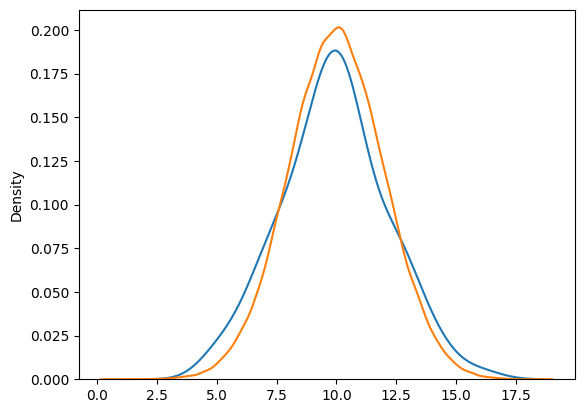

In [ ]:
# посмотрим не различается ли распределение выборки от генеральной совокупности
sns.kdeplot(random_sample)
sns.kdeplot(population_data)

Если посмотреть на графики распределений выборки и генеральной совокупности, то можно увидеть, что распределения похожи. Выборка размером в 100 наблюдений — не самый лучший способ, так как ее мощность будет небольшой, однако даже на таком количестве наблюдений паттерн и центральная тенденция угадываются.

#### scipy.stats.bernoulli.rvs()

Посмотрим еще один способ доставать выборку. Иногда нужно доставать выборку через использование булевой маски, когда явно заданы True и False отнесения к выборке A или выборке B. Для этого тоже инициализируем генератор случайных чисел и зададим seed. С помощью метода bernoulli.rvs() построим распределение Бернулли с вероятностью попадания в выборку 0.5 и наложим маску на сгенерированный массив population_data.

In [ ]:
# другой вариант рассчета простой случайной выборки
# иногда удобно хранить деление на выборку в виде маски булевых значений
np.random.seed(1) # важно не забывать про seed, чтобы результаты деления были воспроизводимы
sample_mask = ss.bernoulli.rvs(0.5, size=len(population_data)) # 0.5 - вероятность попадания в выборку
sample_mask
print('Mean', np.mean(population_data[sample_mask==1]))
population_data[sample_mask==1]

Mean 9.993970884191873


array([10.99990267,  7.70504673,  9.82402614, ...,  6.52446045,
        5.97315951, 12.28397835])

In [ ]:
sample_mask, sample_mask==1

(array([0, 1, 0, ..., 1, 1, 1]),
 array([False,  True, False, ...,  True,  True,  True]))

In [ ]:
print('Размер выборки полученный через маску:', len(population_data[sample_mask==1]))
print('Размер генеральной совокупности:', len(population_data))

Размер выборки полученный через маску: 49986
Размер генеральной совокупности: 100000


<AxesSubplot:ylabel='Density'>

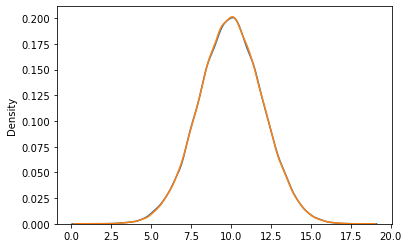

In [ ]:
sns.kdeplot(population_data[sample_mask==1])
sns.kdeplot(population_data)

Если построить графики, то можно увидеть, что они почти закрывают друг друга. Так происходит из-за того, что полученная таким способом выборка достаточно большого размера и очень хорошо воспроизводит генеральную совокупность.

#### pandas.sample()


Также рассмотрим третий способ доставать выборку. Чаще всего данные в python лежат в каком-то датафрейме, из которого нужно получить выборку. Чтобы это сделать, используем функцию sample() из библиотеки pandas для сгенерированного population_dataframe.

In [ ]:
# сделаем dataframe
population_dataframe = pd.DataFrame({'population_data': population_data, 'user_id': np.arange(len(population_data))})
population_dataframe

,population_data,user_id
0,10.101123,0
1,10.999903,1
2,8.008182,2
3,11.387197,3
4,9.163397,4
...,...,...
99995,8.901596,99995
99996,11.949173,99996
99997,6.524460,99997
99998,5.973160,99998


In [ ]:
# используем функцию sample из Pandas
np.random.seed(1) # важно не забывать про seed, чтобы результаты деления были воспроизводимы
random_sample = population_dataframe.sample(frac = 0.5, random_state = 1)
print('sample_size =', len(random_sample))
print('sample mean =', random_sample['population_data'].mean())
random_sample.head(5)

sample_size = 50000
sample mean = 9.99103115502391


,population_data,user_id
43660,10.386192,43660
87278,7.385995,87278
14317,7.646564,14317
81932,8.746168,81932
95321,9.771338,95321


Посмотрим, действительно ли выборки, которые достаются разными способами, репрезентируют или хотя бы похожи друг на друга.

<AxesSubplot:xlabel='population_data', ylabel='Density'>

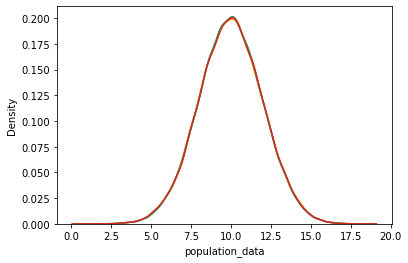

In [ ]:
# посмотрим визуально не различаются ли простые случайные выборки сгенерированные различными способами
sns.kdeplot(population_dataframe['population_data'])

sns.kdeplot(random_sample['population_data'])
sns.kdeplot(population_dataframe['population_data'])
sns.kdeplot(population_data[sample_mask==1])

Видно, что разными способами мы получили распределения, которые практически не отличаются друг от друга и близки к генеральной совокупности. Можно пока предполагать, что такой способ доставать выборки позволяет хорошо репрезентировать генеральную совокупность.

### Систематическая (интервальная) случайная выборка

Создадим небольшую функцию, которая на вход будет принимать датафрейм. Она будет создавать порядковые id, инициализировать первый элемент и инициализировать выбор индексов с каким-то шагом, который был передан во входных параметрах:

In [ ]:
# функция, которая формирует систематическую случайную выборку из n-элементов
def systematic_sampling(df, step):
    id = pd.Series(np.arange(0, len(df), 1))
    df = pd.Series(df)
    df_pd = pd.concat([id, df], axis = 1)
    df_pd.columns = ["id", "data"]

    # определяем первый случайный элемент выборки и передаем интервал
    first = np.random.randint(0, 10)
    selected_index = np.arange(first, len(df), step)

    # формируем датасет систематической выборки
    systematic_sampling = df_pd.iloc[selected_index]
    return(systematic_sampling)

# задаем размер выборки и вычисляем интервал из совокупности данных
n = 10000 # желаемый размер выборки
step = int(N/n) # N = 100000

systematic_sample = systematic_sampling(population_dataframe['population_data'], step)
systematic_sample

,id,data
5,5,6.830846
15,15,10.701994
25,25,10.788590
35,35,11.675673
45,45,11.604173
...,...,...
99955,99955,11.008031
99965,99965,13.608301
99975,99975,8.482935
99985,99985,11.650167


В результате работы функции формируется какой-то систематический sample. Представим, что мы работаем с тем же датасетом, который сформировали ранее (N = 100000), и хотим сформировать выборку в тысячу элементов (n = 1000). Отсюда мы находим, какой нужен степ: step = int(N/n)

<AxesSubplot:xlabel='data', ylabel='Density'>

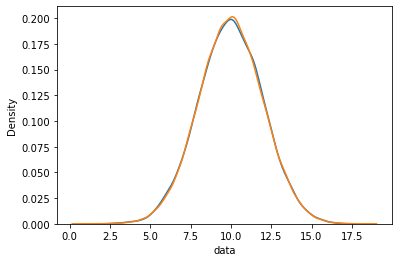

In [ ]:
# посмотрим визуально на функцию плотности ген совокупности и случайной выборки
sns.kdeplot(systematic_sample['data'])
sns.kdeplot(population_dataframe['population_data'])

### Кластерная случайная выборка

Сформируем кластерную выборку, попытаемся рандомизировать не отдельные наблюдения, а кластеры, в которых эти наблюдения находятся. Попробуем сгенерировать данные.

Понятие кластера существует априори. Это может быть, например, школа, какой-то цех в заводе. Напишем функцию, которая создает кластеры к исходному датасету.

In [ ]:
# генерация совокупности данных
price_vb = pd.Series(np.random.uniform(1,4,size = N))
id = pd.Series(np.arange(0,len(price_vb),1))
event_type = pd.Series(np.random.choice(['type1','type2','type3'], size = len(price_vb)))
click = pd.Series(ss.bernoulli.rvs(0.5, size=len(price_vb)))
df = pd.concat([id,price_vb,event_type, click],axis = 1)
df.columns = ['id', 'price', 'event_type', 'click']
df.head()

,id,price,event_type,click
0,0,1.955384,type1,1
1,1,2.800858,type1,1
2,2,1.377146,type1,1
3,3,2.030908,type3,1
4,4,3.233164,type2,0


In [ ]:
df

,id,price,event_type,click
0,0,1.955384,type1,1
1,1,2.800858,type1,1
2,2,1.377146,type1,1
3,3,2.030908,type3,1
4,4,3.233164,type2,0
...,...,...,...,...
99995,99995,2.563205,type1,0
99996,99996,1.945927,type1,0
99997,99997,2.323637,type1,0
99998,99998,3.776491,type1,1


In [ ]:
# создадим функцию, которая из датасета делает кластерную выборку.
# В реальности кластера это определенные группы имеющиеся априори. Например школы. Но для симуляции попробуем создавать их синтетически

def get_clustered_sample(df, n_per_cluster, num_select_clusters):

    N = len(df) # Размер датасета
    K = int(N/n_per_cluster) # кол-во кластеров
    data = None

    for k in range(K):
        sample_k = df.sample(n_per_cluster)  #рандомно формируем требуемую случайную выборку
        sample_k['cluster'] = np.repeat(k,len(sample_k)) # повторением получаем номер кластера для всех элементов группы в этой итерации
                                                        # (при следующем цикле k-группы номер кластера будет другой)

        df = df.drop(index = sample_k.index) # (избавляемся от индекса в датасете номера кластера) удалям наблюдения с присвоенным кластером из первоначального датасета
        data = pd.concat([data,sample_k],axis = 0) # (добавляем номер кластера к данным выборки) добавляем наблюдения с присвоенным кластером в новый датасет

    random_chosen_clusters = np.random.choice(data['cluster'].unique(), size = num_select_clusters, replace = False) #формируем выборку из номеров кластеров нужного размера
    samples = data[data.cluster.isin(random_chosen_clusters)] # для случайно выбранных кластеров извлекаем данные (выбираем все наблюдения из случайно выбранных кластеров)
    return(samples, data)

clust_sample, data = get_clustered_sample(df = df, n_per_cluster = 50, num_select_clusters = 50)
clust_sample

,id,price,event_type,click,cluster
71966,71966,1.376311,type3,0,2
76069,76069,1.618280,type1,1,2
19898,19898,3.854243,type3,0,2
73703,73703,1.480351,type1,0,2
37187,37187,3.672678,type1,0,2
...,...,...,...,...,...
49428,49428,2.803930,type2,1,1977
29935,29935,2.644440,type2,0,1977
71746,71746,3.273480,type1,0,1977
17426,17426,1.832503,type1,0,1977


In [ ]:
clust_sample.groupby('cluster', as_index=False).agg({'id':'count', 'price':'mean'})

,cluster,id,price
0,2,50,2.623253
1,53,50,2.386608
2,107,50,2.547710
3,174,50,2.469684
4,175,50,2.546192
5,202,50,2.433381
6,230,50,2.656778
7,264,50,2.624485
8,297,50,2.605737
9,309,50,2.533832


In [ ]:
data

,id,price,event_type,click,cluster
70347,70347,1.748489,type3,0,0
72197,72197,1.401280,type3,0,0
984,984,3.484102,type1,1,0
97818,97818,2.436471,type3,1,0
7047,7047,3.829201,type1,0,0
...,...,...,...,...,...
99107,99107,2.433212,type1,1,1999
79762,79762,2.179944,type1,1,1999
27890,27890,3.254330,type3,0,1999
50490,50490,1.337238,type3,0,1999


In [ ]:
data.groupby('cluster', as_index=False).agg({'id':'count', 'price':'mean'})

,cluster,id,price
0,0,50,2.658031
1,1,50,2.374472
2,2,50,2.623253
3,3,50,2.591609
4,4,50,2.545601
...,...,...,...
1995,1995,50,2.468287
1996,1996,50,2.530799
1997,1997,50,2.583365
1998,1998,50,2.633678


<AxesSubplot:xlabel='price', ylabel='Density'>

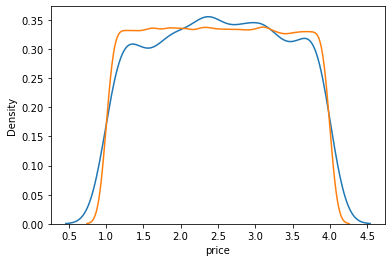

In [ ]:
# посмотрим визуально распределения в ген совокупности и кластерной выборке
sns.kdeplot(clust_sample['price'])
sns.kdeplot(df['price'])

### Стратифицированная случайная выборка

Стратифицированная выборка вторая по популярности после случайной, потому что стратификация — это полезно, такую выборку периодически используют. Для начала подготовим датасет со следующими данными: user_id, пользуется ли клиент дополнительными платными услугами (параметр ‘vas’) и какую платформу он использует в приложении android или ios (параметр ‘platform’). Страты полезно и удобно воспринимать как, например, платформу.

Пусть средний процент платящих у нас получится 0,2, вероятность android равна 70, а вероятность ios равна 30, то есть, в датасете наблюдается явный дисбаланс.

Получим 5-процентную стратифицированную выборку. Код, возвращающий стратифицированную выборку, очень простой, он достает нужную долю пользователей для каждой из платформ и выглядит вот так:

Подготовим датасет, включающий данные о том, пользуется ли пользователь дополнительными платными услугами и какую платформу использует для доступа к приложению:
- Доля платящих пользователей (обозначены 1) равна 20%,
- Платформы распределены в соотношении 70% Android и 30% iOS

In [ ]:
# Подготовим датасет из 100 тыс.пользователей
n_rows = 100000
df = pd.DataFrame(dict(
    user_id = np.arange(0, n_rows),
    vas = np.random.binomial(1, 0.2, size=n_rows), # зададим флаг были ли покупки vas услуг
    platform = random.choices(['android', 'ios'], weights=(70, 30), k=n_rows) # рандомно присвоим платформу с заданными вероятностями
))

# проверим соотношение типов пользователей по платежному поведению и платформам в сгенерированном датасете
print(df[['vas','platform']].value_counts())
df.head()

vas  platform
0    android     55817
     ios         24020
1    android     14076
     ios          6087
dtype: int64


,user_id,vas,platform
0,0,1,android
1,1,0,android
2,2,0,android
3,3,0,android
4,4,0,android


Получим 5-процентную стратифицированную выборку. Код, возвращающий стратифицированную выборку, очень простой, он достает нужную долю пользователей для каждой из платформ и выглядит вот так:

In [ ]:
df.groupby(['vas','platform'], group_keys = False)

In [ ]:
# Получим 5%-ю стратифицированную выборку по платформе
strat_sample_dataset_1 = (df.groupby(['vas','platform'], group_keys = False).apply(lambda x: x.sample(frac=0.005)))

strat_sample_dataset_1

,user_id,vas,platform
46505,46505,0,android
31913,31913,0,android
20005,20005,0,android
86021,86021,0,android
9917,9917,0,android
...,...,...,...
40807,40807,1,ios
62392,62392,1,ios
77828,77828,1,ios
836,836,1,ios


Сгенерируем также рандомную случайную выборку с помощью sample из pandas. И сравним, какой процент платящих получился в генеральной совокупности, в стратифицированной и в случайной. Доля платящих пользователей в генеральной совокупности — это 19,7%. В стратифицированной выборке очень близко — 19,7%. А в случайной выборке значение чуть завышено. Среднее при выборке в 500 пользователей равно 21,8%. Этот пример показывает, что может быть искажение, если делать простую случайную выборку.

In [ ]:
# Получим 5%-ю простую случайную выборку по платформе
random_df_sample = df.sample(frac = 0.005)

In [ ]:
# проверим соотношение платящих и не платящих пользователей в выборке
print('Доля платящих пользователей в ген совокупности:', df['vas'].mean())
print('Доля платящих пользователей в стратифицированной выборке:', strat_sample_dataset_1['vas'].mean())
print('Доля платящих пользователей в случайной выборке:', random_df_sample['vas'].mean())

Доля платящих пользователей в ген совокупности: 0.20042
Доля платящих пользователей в стратифицированной выборке: 0.20159680638722555
Доля платящих пользователей в случайной выборке: 0.194


Как видно из долей выше на небольшой выборке стратифицированный алгоритм показывает более близкое к ген совокупности распределение доли платящих

Посмотрим, как представлены платформы в разных способах извлечения выборки и в генеральной совокупности. В исходной генеральной совокупности доля андроида составляет 70,1%, стратифицированная выборка показала близкое значение — 70,05%, а случайная выборка завысила значение — 72,4%. Это показывает, что случайные выборки могут искажать паттерны, заложенные в генеральную совокупность.

In [ ]:
# проверим как представлены платформы в выборке

print('Доля android в генеральной совокупности:', (df['platform']=='android').mean())
print('Доля android в стратифицированной выборке:', (strat_sample_dataset_1['platform']=='android').mean())
print('Доля android в случайной выборке:', (random_df_sample['platform']=='android').mean())

Доля android в генеральной совокупности: 0.70159
Доля android в стратифицированной выборке: 0.7005988023952096
Доля android в случайной выборке: 0.746


# Способы сплитования на реальных данных

Мы посмотрели, как доставать выборки на сгенерированных данных. Посмотрим, как доставать выборки на реальных данных. Представим, что приходит менеджер и ставит задачу разделить базу клиентов в соотношении 20/80 и 80 процентам пользователей требуется рассылка пуш-уведомлений. Для этого 80 процентов пользователей нужно достать рандомно. Попробуем достать простую случайную выборку и записать в датафрейм df_user_passports столбец simple_random_group, который показывает, тестовая группа или контрольная. Здесь пригодится конструкция с булевой маской, так как она позволяет достать массив и вставить его в столбец.

Получение данных о пользователях из базы

```
SELECT up.execution_date, up.created_at, up.passport_id, up.global_id, up.user_type_cars_name
FROM `user_passports_res_anon` AS up
ORDER BY up.execution_date
```

In [ ]:
df_user_passports = pd.read_csv('user_passports.csv', encoding = 'utf-8')
df_user_passports.head(5)

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN
2,2022-10-09,135557519,139948206,cim2q5xvQIWCapTXUhF0zg==,2019-07-30 17:04:46,0,simple_user,NaN,0,cars_simple,NaN
3,2022-10-09,133420705,136724165,UIobyHts94BY2MD1LbwNGA==,2018-11-07 23:46:45,0,simple_user,NaN,0,cars_simple,NaN
4,2022-10-09,140030534,144336261,28/pxuvy7mrZYZXi1buenQ==,2020-11-14 21:39:58,0,simple_user,NaN,0,cars_simple,NaN


### scipy.stats.bernoulli.rvs()

In [ ]:
# Рандомная выборка с присвоением контрольной или тестовой группы

np.random.seed(3) # важно не забывать про seed, чтобы результаты деления были воспроизводимы
sample_mask = ss.bernoulli.rvs(0.8, size=len(df_user_passports))
df_user_passports['simple_random_group'] = sample_mask

df_user_passports['simple_random_group'].value_counts(normalize = True)

1    0.802391
0    0.197609
Name: simple_random_group, dtype: float64

In [ ]:
df_user_passports.head()

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,simple_random_group
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN,1
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN,1
2,2022-10-09,135557519,139948206,cim2q5xvQIWCapTXUhF0zg==,2019-07-30 17:04:46,0,simple_user,NaN,0,cars_simple,NaN,1
3,2022-10-09,133420705,136724165,UIobyHts94BY2MD1LbwNGA==,2018-11-07 23:46:45,0,simple_user,NaN,0,cars_simple,NaN,1
4,2022-10-09,140030534,144336261,28/pxuvy7mrZYZXi1buenQ==,2020-11-14 21:39:58,0,simple_user,NaN,0,cars_simple,NaN,0


In [ ]:
len(df_user_passports)

9367

### Hash-функция (murmurhash2, murmurhash5, spookyhash)

Предположим, что мы хотели бы это сделать не с помощью стат-пакета, а с помощью hash-функции.

Установим пакет murmurhash2. Преобразуем с помощью hash-функции глобальный идентификатор пользователя, а ее, в свою очередь, превратить в integer и integer-число разбить на бакеты, используя остаток от деления Так, база будет разбита на 100 микро-групп бакетов, а в каждый бакет попадет относительно рандомное число пользователей.

In [ ]:
!pip install murmurhash2
import hashlib
from murmurhash2 import murmurhash2, murmurhash3

df_user_passports['global_id'] = df_user_passports['global_id'].astype(str)
df_user_passports['md5'] = ([hashlib.md5(val.encode('UTF-8')).hexdigest() for val in df_user_passports['global_id']])
df_user_passports['md5'] = df_user_passports['md5'].apply(int, base=16)

# Рандомизация зарегистрированных пользователей по бакетам с использованием остатка от деления

# отрезаем последний символ id (может быть нерандомным)
df_user_passports['global_id_transformed'] = df_user_passports['md5'] // 10

# используем остаток от деления id пользователя для распределения по бакетам для md5
df_user_passports['bucket_id'] = df_user_passports['global_id_transformed'] % 100

print('Размер исходного датасета', len(df_user_passports))
df_user_passports.groupby(['bucket_id']).count()['passport_id']

Размер исходного датасета 9367


bucket_id
0      88
1     107
2      81
3      88
4      99
     ... 
95    106
96    101
97     93
98     81
99    100
Name: passport_id, Length: 100, dtype: int64

In [ ]:
df_user_passports.head()

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,simple_random_group,md5,global_id_transformed,bucket_id
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN,1,300480812144854033254122193569131109097,30048081214485403325412219356913110909,9
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN,1,95113019812368846327928754511395983931,9511301981236884632792875451139598393,93
2,2022-10-09,135557519,139948206,cim2q5xvQIWCapTXUhF0zg==,2019-07-30 17:04:46,0,simple_user,NaN,0,cars_simple,NaN,1,248958859067613554490456990646941501831,24895885906761355449045699064694150183,83
3,2022-10-09,133420705,136724165,UIobyHts94BY2MD1LbwNGA==,2018-11-07 23:46:45,0,simple_user,NaN,0,cars_simple,NaN,1,187479745211920398225691779451573368650,18747974521192039822569177945157336865,65
4,2022-10-09,140030534,144336261,28/pxuvy7mrZYZXi1buenQ==,2020-11-14 21:39:58,0,simple_user,NaN,0,cars_simple,NaN,0,264181220687091912395873616418528643636,26418122068709191239587361641852864363,63


Можно попробовать другие hash-функции, например, mumurhash2 или spookyhash из пакета spookyhash.

In [ ]:
# другие варианты хеш-функций
# хеш-функция mumurhash2
seed = 1
df_user_passports['mumurhash2'] = ([murmurhash2(val.encode('UTF-8'), seed) for val in df_user_passports['global_id']])

# хеш-функция spookyhash
!pip install spookyhash

import spookyhash
df_user_passports['spookyhash'] = ([spookyhash.hash32(val.encode('UTF-8'), seed) for val in df_user_passports['global_id']])

Посмотрим, как выглядит датафрейм теперь. Появилась пара новых столбцов murmurshash2 и spookyhash.

In [ ]:
df_user_passports.head()

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,simple_random_group,md5,global_id_transformed,bucket_id,mumurhash2,spookyhash
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN,1,300480812144854033254122193569131109097,30048081214485403325412219356913110909,9,2056483722,3783523981
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN,1,95113019812368846327928754511395983931,9511301981236884632792875451139598393,93,2660533847,805114337
2,2022-10-09,135557519,139948206,cim2q5xvQIWCapTXUhF0zg==,2019-07-30 17:04:46,0,simple_user,NaN,0,cars_simple,NaN,1,248958859067613554490456990646941501831,24895885906761355449045699064694150183,83,1078280488,1663311133
3,2022-10-09,133420705,136724165,UIobyHts94BY2MD1LbwNGA==,2018-11-07 23:46:45,0,simple_user,NaN,0,cars_simple,NaN,1,187479745211920398225691779451573368650,18747974521192039822569177945157336865,65,664369164,458675156
4,2022-10-09,140030534,144336261,28/pxuvy7mrZYZXi1buenQ==,2020-11-14 21:39:58,0,simple_user,NaN,0,cars_simple,NaN,0,264181220687091912395873616418528643636,26418122068709191239587361641852864363,63,2426260465,2065425089


Попробуем разделить бакетную группу по значениям столбца murmurhash2.

In [ ]:
# используем остаток от деления id пользователя для распределения по бакетам для mumurhash2. Делим на 100 бакетов
df_user_passports['bucket'] = df_user_passports['mumurhash2'] % 100

# разделяем на группы в соотнноении 80:20 (все бакеты до 80 относятся к группе А1)
df_user_passports['bucket_group'] = np.where(df_user_passports['bucket'] <= 80, 'A', 'B')

In [ ]:
df_user_passports.head()

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,simple_random_group,md5,global_id_transformed,bucket_id,mumurhash2,spookyhash,bucket,bucket_group
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN,1,300480812144854033254122193569131109097,30048081214485403325412219356913110909,9,2056483722,3783523981,22,A
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN,1,95113019812368846327928754511395983931,9511301981236884632792875451139598393,93,2660533847,805114337,47,A
2,2022-10-09,135557519,139948206,cim2q5xvQIWCapTXUhF0zg==,2019-07-30 17:04:46,0,simple_user,NaN,0,cars_simple,NaN,1,248958859067613554490456990646941501831,24895885906761355449045699064694150183,83,1078280488,1663311133,88,B
3,2022-10-09,133420705,136724165,UIobyHts94BY2MD1LbwNGA==,2018-11-07 23:46:45,0,simple_user,NaN,0,cars_simple,NaN,1,187479745211920398225691779451573368650,18747974521192039822569177945157336865,65,664369164,458675156,64,A
4,2022-10-09,140030534,144336261,28/pxuvy7mrZYZXi1buenQ==,2020-11-14 21:39:58,0,simple_user,NaN,0,cars_simple,NaN,0,264181220687091912395873616418528643636,26418122068709191239587361641852864363,63,2426260465,2065425089,65,A


In [ ]:
df_user_passports['bucket_group']

0       A
1       A
2       B
3       A
4       A
       ..
9362    A
9363    A
9364    A
9365    A
9366    A
Name: bucket_group, Length: 9367, dtype: object

In [ ]:
df_user_passports.head(2)

,execution_date,passport_id,global_id,login,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,simple_random_group,md5,global_id_transformed,bucket_id,mumurhash2,spookyhash,bucket,bucket_group
0,2022-10-09,124025991,124004987,VmDe/C8T2IDkaDjxIZ+4PA==,2013-03-28 13:46:39,0,simple_user,NaN,0,cars_simple,NaN,1,300480812144854033254122193569131109097,30048081214485403325412219356913110909,9,2056483722,3783523981,22,A
1,2022-10-09,142763752,147740704,ykf6nPFfGDOmvQ8+Wm7IFA==,2021-12-22 17:35:16,0,simple_user,NaN,0,cars_simple,NaN,1,95113019812368846327928754511395983931,9511301981236884632792875451139598393,93,2660533847,805114337,47,A


Все, что мы здесь сделали — это определили, какой бакет относится к какой группе. Если номер бакета меньше 80, то он оказывается в группе A, если больше, либо равен — то в группе B.

Посмотрим, если бы мы захотели сделать выборку не с помощью простой случайной или хэшированной функции. Предположим, менеджер говорит, что важна более полная представленность по типам пользователей.

In [ ]:
# стратифицированная выборка по типу пользователя
df_sample = (df_user_passports.groupby(['user_type_cars_name'], group_keys=False).apply(lambda x:x.sample(frac=0.2)))

df_sample['user_type_cars_name'].value_counts(normalize = True)

cars_simple    0.937533
cars_seller    0.056594
cars_dealer    0.005873
Name: user_type_cars_name, dtype: float64

In [ ]:
# исходное распределение по типу пользователя
df_user_passports['user_type_cars_name'].value_counts(normalize = True)

cars_simple    0.937440
cars_seller    0.056475
cars_dealer    0.006085
Name: user_type_cars_name, dtype: float64

In [ ]:
# исходное распределение по типу пользователя
df_user_passports[df_user_passports['simple_random_group'] == 1]['user_type_cars_name'].value_counts(normalize = True)

cars_simple    0.936801
cars_seller    0.056812
cars_dealer    0.006386
Name: user_type_cars_name, dtype: float64

In [ ]:
# распределение по типу пользователя в простой случайной выборке
df_user_passports[df_user_passports['simple_random_group'] == 0]['user_type_cars_name'].value_counts(normalize = True)

cars_simple    0.940032
cars_seller    0.055105
cars_dealer    0.004862
Name: user_type_cars_name, dtype: float64

Мы помним, что стратифицированная выборка старается эту проблему решить. Если сравнить представленность типов пользователей в стратифицированной выборке, случайной выборке и генеральной совокупности, то увидим, что в доли в стратифицированной выборке и генеральной совокупности совпадают с точностью до 0.0001%. А отличие случайной - 0.003%. Кажется, что это не критично, но искажение уже заметно, и представленность одной из групп была бы выше или ниже.

In [ ]:
# распределение по группам в разрезе дилеров 80:20
df_sample[df_sample['user_type_cars_name'] == 'cars_dealer']['bucket_group'].value_counts()

A    9
B    2
Name: bucket_group, dtype: int64

# Ошибки формирования выборок

1. Смещённая выборка (**sampling bias**) - часть генеральной совокупности систематически недопредставлена.
>Примеры:
>- Опрос только пользователей iPhone и выводы о всех смартфон-пользователях.
>- Эксперименты только в рабочие часы, когда доступна определённая категория пользователей.

2. **SRM (Sample Ratio Mismatch)** - фактическое распределение по группам отличается от ожидаемого. Последствия: большая вероятность ошибок II рода (ложноотрицательных выводов).

3. **Нерандомизированная выборка** - элементы выборки выбираются не случайным образом. Последствия: нарушение условий применимости многих статистических тестов (например, t-теста или χ²-теста).

4. **Слишком малая выборка** - выборка недостаточна для статистически значимых выводов. Последствия: высокая дисперсия, широкие доверительные интервалы, большая вероятность ошибок II рода (ложноотрицательных выводов).

5. **Перекрытие (overlap**) между контрольной и тестовой группой - одни и те же пользователи (или объекты) попадают в обе группы. Последствия: невалидные сравнения, «размывание» эффекта, утечка информации.

6. **Сезонность или временные аномалии** - выборка берётся в нехарактерный период.
>Пример: данные только из новогоднего периода — несравнимы с обычными неделями.

7. **Выборка по зависимым наблюдениям** - данные в выборке не являются независимыми (например, несколько заказов от одного клиента). Последствия: переоценка точности, нарушаются допущения многих методов.

8. **Выборка на основе действия (self-selection bias)** - пользователи сами выбирают, участвовать ли в эксперименте или нет.
>Пример: опрос среди активных пользователей, игнорируя тех, кто не заходит в сервис.

9. **Утечка данных (data leakage)** - информация из будущего или из других частей данных попадает в выборку и влияет на результат. Сюда же можно отнести **нарушение SUTVA** stable unit treatment value value assumption - воздействие на одну группу оказывает влияние на результат в других группах (сетевой эффект). Последствия: эффект от эксперимента «размазывается» и становится недостоверным, полученные различия уже не являются чистым эффектом вмешательства.
>Пример:
>- В обучение модели попадают признаки, содержащие целевую переменную
>- Пользователи из контрольной группы видят рекламу, показанную тестовой групп
>- Пользователи делятся промокодами между группами.

10. **Ошибка выжившего (Survivorship Bias)** - учитываются только «выжившие» элементы, игнорируя выбывшие.
>Пример: анализируем только успешные стартапы, забывая про провалившиеся.

11. **Смещение из-за отклика (Non-response Bias)** - не все участники отвечают, и отвечающие отличаются по характеристикам.
>Пример: участвуют только активные пользователи, игнорируются пассивные.

## Проверка на несбалансированность выборки (SRM)

Проблема несбалансированности не означает, что выборки всегда должны формироваться в пропорции 1/1. Могут быть заданы любые пропорции, целнсообразные с точки зрения бизнеса, но при этом важно учитывать следующее: мощность теста зависит от пропорции выборок, поэтому если на этапе сплитования размеры выборок "поехали" относительно тех, которые были получены на этапе дизайна эксперимента - увеличится вероятность ошибки II рода, когда альтернативная гипотеза ошибочно отвергается. Поэтому важно соблюдать заданную в ходе дизайна пропорцию выборок

**несбалансированность выборки - это не всегда SRM**, иногда деление в пропорции 30/70 — это не проблема, а особенности дизайна эксперимента.

Когда используются несбалансированные выборки:

- При высоком риске серьезных потерь при отрицательном результате эксперимента (потеря продуктом денег при изменении цены на услуги, риск оттока пользователей после нововведения);
- На ранней стадии внедрения новой фичи.

Для несбалансированной выборки ее размер для сохранения мощности рассчитывается по формуле:

$$\frac{(k-1)^2}{4*k}*N$$

где $k$ - отношение между несбалансированными выборками

$N$ - размер выборки при равенстве групп

Использование несбалансированных выборок влияет на мощность теста. Так, при делении 80/20 необходимо увеличивать размер выборки на 56% от сбалансированного уровня.

В Python уже есть решение — функция `tt_ind_solve_power()`. Она содержит параметр `ratio`, который напрямую задает **отношение количества наблюдений в группе 2 к количеству наблюдений в группе 1**. Здесь важен порядок: делим именно группу 2 на группу 1, а не наоборот

In [ ]:
sample_2, sample_1 = 50, 50
ratio =  sample_2 / sample_1
sample_1_size = tt_ind_solve_power(effect_size = 0.1,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = ratio,
                       alternative = "two-sided",
                       nobs1 = None)
sample_2_size = sample_1_size/ratio
print('Размер выборки 1 равен: {}, Размер выборки 2 равен: {}'.format(round(sample_1_size), round(sample_2_size)))
print('Общая необходимая численность наблюдений = ', round(sample_1_size + sample_2_size))
#ratio : float
#    ratio of the number of observations in sample 2 relative to
#    sample 1. see description of nobs1
#    The default for ratio is 1; to solve for ratio given the other
#    arguments it has to be explicitly set to None.

Размер выборки 1 равен: 1571, Размер выборки 2 равен: 1571
Общая необходимая численность наблюдений =  3141


Видим, что для того, чтобы обнаруживать стандартизированный MDE в 0,1 при alpha=0,05 и мощности 0,8 двухстороннего критерия, нам потребуется 1571 наблюдение. Общая численность пользователей, прошедших через тест, будет равно 3141.

Представим, что все остальные параметры остаются прежними, но мы хотим сделать 40/60, то есть выборка 2 маленькая, а выборка 1 — большая. Запускаем код.

После запуска кода видны изменения: выборка 1 стала больше, она уже не 1571, а 1963. Что интересно — выборка 2 тоже растет. Общая численность пользователей, которые должны поучаствовать в эксперименте теперь равна 4908.

Это простой код, позволяющий прикинуть, какой баланс нужен. Однако, бизнесовую сторону необходимо будет обсуждать с менеджером.

In [ ]:
sample_2, sample_1 = 40, 60
ratio =  sample_2 / sample_1
sample_1_size = tt_ind_solve_power(effect_size = 0.1,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = ratio,
                       alternative = "two-sided",
                      nobs1 = None)
sample_2_size = sample_1_size/ratio
print('Размер выборки 1 равен: {}, Размер выборки 2 равен: {}'.format(round(sample_1_size), round(sample_2_size)))
print('Общая необходимая численность наблюдений = ', round(sample_1_size + sample_2_size))


Размер выборки 1 равен: 1963, Размер выборки 2 равен: 2945
Общая необходимая численность наблюдений =  4908


>Лучше работать со сбалансированными выборками, потому что несбалансированные выборки часто сильно удлиняют принятие решения и иногда проще провести два теста со сбалансированными выборками, чем один длинный с несбалансированными. Придерживайтесь тех методов, которые дают наибольшую мощность, это будет означать, что вы будете проводить тесты быстрее, чем в случае проведения тестов с меньшей мощностью.

Пример: на этапе дизайна мы определили, что пропорция тестовой и контрольной выборок при прочих требуемых параметрах составит 1/1

**Гипотезы:**
- H0 - соотношение между размерами выборок 1:1
- Ha - соотношение между размерами выборок не 1:1

По итогам эксперимента нужно проверить, что заданное нами предположение не нарушено. Для проверки этой гипотезы можно использовать критерий хи-квадрат, z-тест для пропорций или последовательное наблюдение из библиотеки Optimizely

### Chi-square

Проверка на несбалансированность выборки (SRM)

Попробуем кодом поработать с SRM.

Начнем с критерия chi-квадрат, который так же, как z-тест, работает с оценкой долей и частот появления значений в данных:

$$
\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i}
$$

In [ ]:
# введите текущее число пользователей в тестовой и контрольной группах
observed = [170471, 170462]

# введите соотношение между двумя группами (достаточно % для одной из групп)
ratio = 50

# введите уровень значимости
alpha = 0.05

Мы указываем, какие частоты мы видим на текущий момент в группе A и в группе B. Предположим, что это 170471 и 170462. Мы ожидали 50% распределения. Указываем, с каким уровнем значимости мы готовы проверять гипотезу о том, что есть SRM.

In [ ]:
total_traffic = sum(observed)

expected = [ (total_traffic * ratio)/100, (total_traffic * (100 - ratio)/100) ] # ожидаемые размеры групп если бы ratio выполнялось полностью
print('Real sample sizes:', observed)
print('Expected sample sizes:', expected)

chi = ss.chisquare(observed, f_exp = expected) # считаем результаты точечной оценки доли через хи-квадрат критерий

if chi[1] < alpha:
    print('SRM, присутствует!!!')
else:
    print('SRM отсутствует')
print(chi)

Real sample sizes: [170471, 170462]
Expected sample sizes: [170466.5, 170466.5]
SRM отсутствует
Power_divergenceResult(statistic=0.00023758333748859746, pvalue=0.9877021029149465)


Суммарный трафик — это сумма пользователей в районе 340000. Указываем, какие частоты были бы ожидаемы. Ожидаемы — это суммарный трафик, деленный на ожидаемую частоту в 50%. Загружаем в качестве аргументов для метода ss.chisquare() наблюдаемый и ожидаемый массивы. В результате работы этого метода получится два значения: сам chi-квадрат и наблюдаемый p-value.

In [ ]:
ss.chisquare([170471, 170462], f_exp = [(170471+170462)*0.5, (170471+170462)*0.5])

Power_divergenceResult(statistic=0.00023758333748859746, pvalue=0.9877021029149465)

Мы видим, что реальные значения — 170471 и 170462, ожидаемые — по 170466,5, p-value равен 0,98. SRM явно отсутствует, диспропорции нет.

Попробуем задать диспропорцию, добавив две тысячи пользователей в одну из групп.

Теперь SRM присутствует, а p-value стало очень низкое и равно значению в 0,0006. Ожидаемая частота немного изменилась. В группе B находится 172462 пользователя, а должно было находиться 171466. В реальности, если бы мы увидели такие наблюдаемые частоты, при том, что мы ждали другие значения, надо было бы сказать, что SRM присутствует.

In [ ]:
ss.chisquare([170471+2000, 170462], f_exp = [(170471+170462+2000)*0.5, (170471+170462+2000)*0.5])

Power_divergenceResult(statistic=11.769298959271929, pvalue=0.0006021565203867923)

### z-тест с одной пропорцией

Попробуем находить проблемы с пропорцией выборки с помощью z-теста, который также используется для точечной оценки долей и оценки доверительного интервала какой-то доли.

$$
Z_{calc} = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1 - p_0)}{n}}}
$$

Z-распределение является нормальным, поэтому по нему мы сможем найти нужное критическое значение, рассчитать p-value и понять, действительно ли у нас есть основания полагать, что полученная доля, например, в одной выборке статистически значимо больше, чем ожидаемая. Для этого существуют удобные пакеты в библиотеке statmodels — statmodels.stats.proportion. Нам пригодится функция proportions_ztest, которая на вход принимает количество срабатываний, общее количество наблюдений и ожидаемое значение конверсии.

In [ ]:
# z-тест на одну пропорцию. В данном примере сравнивается ожидаемое значение (nobs*value) и наблюдаемое значение (count)
# функция также может принимать на вход список кол-в наблюдений в выборке и ГС, соответствующих проверяемому параметру (передается в count)
# и список общих количеств наблюдений в выборке и ГС (передается в nobs)
# при этом параметр value не передается

stat, pval = proportions_ztest(count=observed[0], nobs=sum(observed), value=0.5) # считаем точечную оценку доли для z-теста
print('Z-статистика: ', stat, '\np-value: ', pval)

if pval < alpha:
    print('SRM при выбранном alpha присутствует')
else:
    print('SRM отсутствует')

Z-статистика:  0.015413738600868329 
p-value:  0.9877021029106169
SRM отсутствует


Запустим код по данным. Видим, что получили очень похожее значение p-value. SRM отсутствует.

Michael Lindon
A Better Way to Test for Sample Ratio Mismatches (SRMs) and Validate Experiment Implementations </br>
https://medium.com/engineers-optimizely/a-better-way-to-test-for-sample-ratio-mismatches-srms-and-validate-experiment-implementations-6da7c0d64552
    

Код от Optimizely (Linkedin) </br>
https://github.com/michaellindon/ssrm </br>

https://github.com/michaellindon/ssrm/blob/master/notebooks/introduction.ipynb (обучающий блокнот)


### SSRM (Optimizely) - последовательное наблюдение за SRM

Чтобы подробнее ознакомиться с темой SSRM, читайте статью: https://medium.com/engineers-optimizely/a-better-way-to-test-for-sample-ratio-mismatches-srms-and-validate-experiment-implementations-6da7c0d64552

SSRM — это попытка следить за SRM последовательно, делая это через определенное количество пользователей и давать ответ, что SRM присутствует. Когда мы запускаем тест, нужно периодически проверять, нет ли проблем с SRM.

Для этого надо установить пакет `!pip install ssrm-test --user`

Для начала попробуем сгенерировать данные. Предположим, что планируемое распределение трафика между группами A и B это 0,5. Допустим, мы бы хотели проверить, как вел бы себя SSRM, если бы была пропорция 51% и 49%. Представим, что мы хотим симулировать поведение трафика, например, до 163 тысяч человек. Для этого можно использовать различные функции, которые дают реализацию случайной величины. Запустим ячейку кода.

In [1]:
# При NumPy 2.0 возникает ошибка AttributeError: np.Inf was removed in the NumPy 2.0 release. Use np.inf instead.
!pip install numpy==1.26.4

In [2]:
# установка модуля SSRM
!pip install ssrm-test -q

In [3]:
from ssrm_test import ssrm_test

In [ ]:
from scipy.stats import multinomial
np.random.seed(1)

p_0 = [0.5, 0.5] # Планируемое распределение трафика между группами
p = [0.51, 0.49] # Реальное распределение трафика между группами
n = 163707 # Заданное число пользователей (большой размер выбори потребует время для проведения вычислений)

data = multinomial.rvs(1, p, size=n) # Получение синтетических данных
x = np.sum(data, axis=0)[0]
print("Распределение трафика между группами, полученное в ходе эксперимента: {}% и {}%".format(round(100 * x / n, 1), round(100 * (n - x) / n, 1)))

Распределение трафика между группами, полученное в ходе эксперимента: 50.9% и 49.1%


In [ ]:
data, data.shape

(array([[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]]),
 (163707, 2))

In [ ]:
np.sum(data, axis=0), 83329/163707, 80378/163707

(array([83329, 80378]), 0.50901305380955, 0.49098694619045)

Распределение трафика между группами получилось не совсем такое, которое мы ожидали, но близкое.

Попробуем определить на всех данных, видит ли, например, z-критерий проблему с диспропорциями между группами.

In [ ]:
# проверим видит ли SRM z-test
z_test = proportions_ztest(count=x, nobs=n, value=0.5)

print("{} пользователей для контрольной группы".format(x))
print("p-value: {}".format(z_test[1]))

83329 пользователей для контрольной группы
p-value: 2.993730802319865e-13


In [ ]:
proportions_ztest(count=83329, nobs=163707, value=0.5)

(7.2946785007629975, 2.993730802319865e-13)

Запускаем код и понимаем, что z-критерий видит эту проблему, p-value очень низкий. Если бы мы проводили такой тест, то в конце теста могли бы справедливо сказать, что проблема SRM опознана. Кажется, что хочется распознавать эту проблему пораньше. Для этого мы попробуем проверять с помощью последовательного поиска SRM. Будем использовать метод sequential_p_values(), где мы пытаемся доставать для загружаемых данных и для доли h0 последовательную проверку и последовательную выгрузку p-value. Будем сохранять их в специальный массив и потом попробуем это отрисовать и посмотрим, как будет выглядеть график.

Код проводит последовательное тестирование: для каждого наблюдения он пытается провести проверку гипотезы, достать p-value, сложить в список, при этом делая дополнительные корректировки.

Вычисляю... (может занять время)


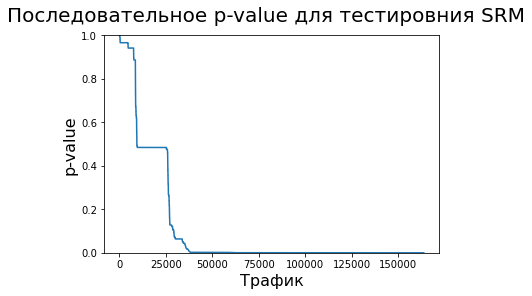

In [ ]:
print("Вычисляю... (может занять время)")
pvals = ssrm_test.sequential_p_values(data, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Последовательное p-value для тестировния SRM", fontsize=20)
plt.xlabel("Трафик", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

Посмотрим на результаты графика. По оси y расположены значения p-value в каждом из проверяемых тестов, а по оси x - трафик, на котором производится проверка гипотезы о том, есть SRM или его нет. Мы видим, что для первых небольших выборок значение p-value очень близко к единице — это значит, что мы пока не можем говорить о том, что SRM присутствует и гипотезу H0 явно не можем отвергнуть. С какого-то момента он падает примерно до 0.5, а около значения "35000 пользователей" становится совсем низкий. По факту, это не самые простые p-value, которые мы делали бы, если бы на каждого нового пользователя запускали z-тест для проверки. Эти p-value скорректированы на то, чтобы выдерживать уровень значимости в 5% в нужном уровне. Основная проблема подглядываний или постоянного проведения тестирования в том, что растет ошибка I рода.

По графику кажется, что наш алгоритм смог найти SRM гораздо раньше достижения 163707 человек. Посмотрим, когда именно.

In [ ]:
sig_reached = np.argmax(np.array(pvals) < 0.05)
print("SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после {} пользователей".format(sig_reached))
print("Это {}% от общего числа пользователей для этого эксперимента".format(round(100 * sig_reached / n), 3))

SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после 34386 пользователей
Это 21% от общего числа пользователей для этого эксперимента


Мы видим, что SRM отклонил нулевую гипотезу об отсутствии SRM при уровне значимости в 5% после 34386 пользователей. Мы могли остановить этот тест раньше и подумать, что могло сломаться на стороне бэкенда или в системе сплитования, перезапустить его и, соответственно, раньше принять какое-либо бизнес-решение. По сути, это случилось на 21% пользователей.

## Влияние объёма трафика на SRM

Подробнее ознакомиться с темой влияния объема трафика на SRM можно в статьях:
- https://towardsdatascience.com/sample-ratio-mismatch-so-many-questions-how-to-answer-them-a86a1893e35
- https://towardsdatascience.com/the-essential-guide-to-sample-ratio-mismatch-for-your-a-b-tests-96a4db81d7a4



Подсветим еще один момент о том, как влияет набор наблюдений или рост трафика на то, в каких доверительных интервалах находится SRM. Интуитивно понятно, что когда 100 человек пришло в A/B-тест и 50/50 разделилось по группам, даже если пропорция составляет 60/40, скорее всего, рано еще говорить о том, что есть проблема. Посмотрим, можно ли в этом случае обнаружить SRM. Для этого напишем небольшой код:

Text(0.5, 1.0, 'Влияние трафика на доверительный интервал оценки попадания в выборкус 50% вероятностью, который возможно задетектить (alpha = 0.05)')

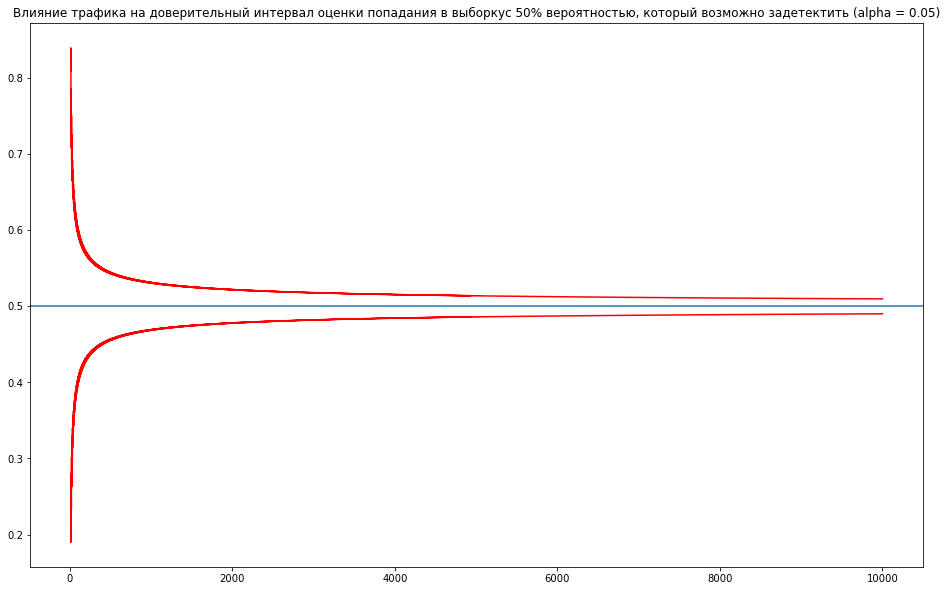

In [ ]:
traffic = np.arange(10, 10000)
p = 0.5
upper_ci_list = []
lower_ci_list = []
for i in traffic:
    ci = proportion_confint(round(i*p), i, alpha = 0.05) #ДИ для биномиального распределения
    lower_ci_list.append(ci[0])
    upper_ci_list.append(ci[1])
plt.figure(figsize=(16,10))
sns.lineplot(x = traffic, y = lower_ci_list, color = 'red')
sns.lineplot(x = traffic, y = upper_ci_list, color = 'red')
plt.axhline(y = p)
plt.title('Влияние трафика на доверительный интервал оценки попадания в выборкус 50% вероятностью, который возможно задетектить (alpha = 0.05)')

Запустим код и видим, что, как и ожидалось, доверительный интервал резко сужается по мере роста выборки. В первых самых значениях он достаточно широкий — от 0,8 до 0,2. Поэтому, даже если мы увидим пропорцию 80/20 — это еще не повод говорить о том, что есть SRM.

Проверим гипотезу о том, в каких границах будет возможно будет распознавать SRM при 100 наблюдениях.

In [ ]:
n=100
p = 0.5
print('При {} наблюдениях, 95%-ДИ для {} доли одной группы составит: {}'. format(n, p, proportion_confint(round(n*0.5), n, alpha = 0.5)))

При 100 наблюдениях, 95%-ДИ для 0.5 доли одной группы составит: (0.46627551249019594, 0.5337244875098041)


При 100 наблюдениях 95%-ый доверительный интервал для доли в 0,5 в одной группе составляет от 46,6% до 53,4%. На самом деле, относительно узкий доверительный интервал. В целом, если видна пропорция 60/40 при ста наблюдениях, скорее всего, можно отвергать гипотезу H0 и говорить, что есть SRM.

## Проверка на репрезентативность (тест Колмогорова-Смирнова)

**Репрезентативность выборки** — это способность представлять изучаемые явления достаточно полно, учитывая их изменчивость в генеральной совокупности. Методы формирования выборки должны обеспечивать ее репрезентативность. Также важно учитывать оценку репрезентативности между конкретной выборкой и ее генеральной совокупностью.

Характер распределения параметров должен быть таким же, как в генеральной совокупности, если нет специальных требований к исследованию. Абсолютно репрезентативных выборок не существует просто в силу случайного характера их формирования. Но уровень расхождений и случайных ошибок не должен быть выше критических значений.

**Чтобы получить репрезентативную выборку необходимо:**

1. Правильно выбрать алгоритм сэмплирования: случайное сэмплирование может не обеспечить репрезентативность выборки в случае если группы, формирующие генеральную совокупность сильно отличаются в процентном соотношении (присутствует неоднородность). Особенно, если размер выборки небольшой.
2. Учитывать размер выборки. Он важен с точки зрения статистической значимости выводов, но не гарантирует репрезентативность выборки.
3. Использовать случайную стратифицированную выборку по наиболее важным параметрам.

Для проверки репрезентативности может быть использован А/А-тест. Его главная цель — получить уверенность в результатах A/B-теста, который будет запущен в тех же условиях, что и A/A-тест путем проверки настройки сервиса и однородности выборки. A/A-тест позволяет убедиться, что сплитование пользователей выполняется корректно и в требуемом соотношении. Пользователи уникальны для контрольной и тестовой группы, данные записываются без ошибок, отсутствует статистически значимая разница между группами.

В чистом виде A/A-тест — затратное решение в плане времени и ресурсов. Компромиссным решением может служить проведение A/A/B-теста, либо техника синтетических A/A-тестов.

Попробуем в коде проверить репрезентативность по некоторым параметрам. На самом деле анализ SRM — это тоже проверка какого-то значения через ее оценку, через статистический критерий. Для разнообразия применим **тест Колмогорова-Смирнова** — критерий согласия, который проверяет, с одного ли распределения получены две выборки или получена ли выборка из генерального распределения.

Сгенерируем нормальное распределение, представим, что это генеральная совокупность из ста тысяч пользователей. Берем выборку размером 100 из того же самого распределения и попробуем провести статистический тест.

KS-test p-value 0.6077321516173053


<AxesSubplot:ylabel='Density'>

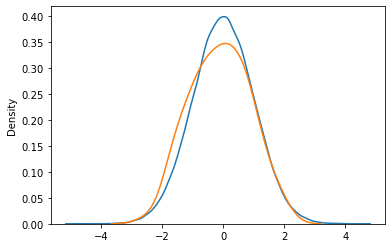

In [ ]:
# Тест Колмогорова-Смирнова
rng=100
# Используем функцию нормального распределения в качестве генеральной совокупности
# Извлечем выборку из 100 элементов, подчиняющихся нормальному распределению
population = ss.norm.rvs(size=100000, random_state=rng)
x1 = ss.norm.rvs(size=100, random_state=rng)

# Проведем тест на репрезентативность выборки, используя критерий Колмогорова-Смирнова,
# где H0: выборка принадлежит нормальному распределению, alpha = 0.05
print('KS-test p-value', ss.kstest(x1, population)[1])

sns.kdeplot(population)
sns.kdeplot(x1)

Мы видим, что p-value очень далека от 0,05, что говорит о том, что даже на такой численности распределения одинаковые и нет возможности отвергнуть нулевую гипотезу.

Что будет, если мы проверим на распределении, которое будет отличаться от нормального? Возьмем логнормальное распределение с параметром 0,3, сделаем аналог генеральной совокупности в сто тысяч единиц и попробуем из другого распределения (тоже из логнормального, но с другим параметром) достать выборку, постепенно увеличивая ее размер.

По результатам теста видно, что чем больше размер выборки - тем больше уверенность теста в том, что выборка отличается

KS-test p-value 0.0006829181048740951


<Axes: ylabel='Density'>

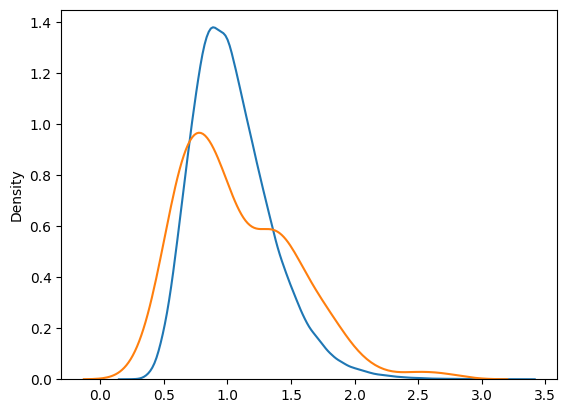

In [ ]:
from scipy.stats import lognorm
# Проведем тест для выборки, которая получена из log-normal распределения

population = ss.lognorm.rvs(0.3, size=100000)
x2 = ss.lognorm.rvs(0.4, size=200)
ss.kstest(x2, population)
print('KS-test p-value', ss.kstest(x2, population)[1])

sns.kdeplot(population)
sns.kdeplot(x2)

KS-test p-value 6.218728865356162e-05


<Axes: ylabel='Density'>

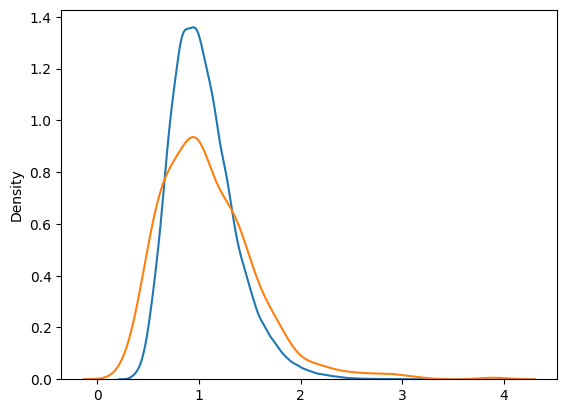

In [ ]:
population = ss.lognorm.rvs(0.3, size=100000)
x2 = ss.lognorm.rvs(0.4, size=500)
ss.kstest(x2, population)
print('KS-test p-value', ss.kstest(x2, population)[1])

sns.kdeplot(population)
sns.kdeplot(x2)

KS-test p-value 4.7001495585727625e-08


<Axes: ylabel='Density'>

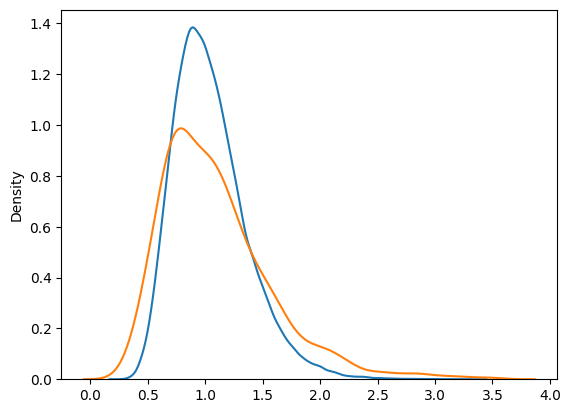

In [ ]:
population = ss.lognorm.rvs(0.3, size=100000)
x2 = ss.lognorm.rvs(0.4, size=1000)
ss.kstest(x2, population)
print('KS-test p-value', ss.kstest(x2, population)[1])

sns.kdeplot(population)
sns.kdeplot(x2)

# Пример формирования стратифицированной выборки

Описание данных:

- passport_id  — локальный ID пользователя
- region  — город, в котором продается авто
- platform  — платформа, через которую было размещено объявление:
android, ios, desktop, mobile

- user_type_cars_nam  — тип кабинета пользователя на момент размещения объявления
- number_ads	- кол-во размещенных объявлений
- revenue - суммарная выручка за всю историю пользователя

In [4]:
df = pd.read_csv('data_for_sample_1.csv')
df = df.dropna().reset_index(drop=True) # удалим пропуски
df

,passport_id,region,platform,user_type_cars_name,number_ads,revenue
0,144161634,Санкт-Петербург,android,cars_seller,2,1080
1,132683716,Калининград,android,cars_simple,1,190
2,142653188,Санкт-Петербург,android,cars_seller,1,0
3,124199631,Казань,android,cars_simple,1,190
4,144045240,Казань,android,cars_simple,1,0
...,...,...,...,...,...,...
130107,144374570,Москва,android,cars_simple,2,1080
130108,144245434,Омск,android,cars_simple,1,190
130109,134759767,Самара,ios,cars_simple,1,580
130110,123856725,Москва,ios,cars_simple,2,0


In [8]:
df.describe().T[1:]

,count,mean,std,min,25%,50%,75%,max
number_ads,130112.0,1.167948,1.246477,1.0,1.0,1.0,1.0,196.0
revenue,130112.0,526.549265,2683.503425,0.0,0.0,190.0,380.0,479858.0


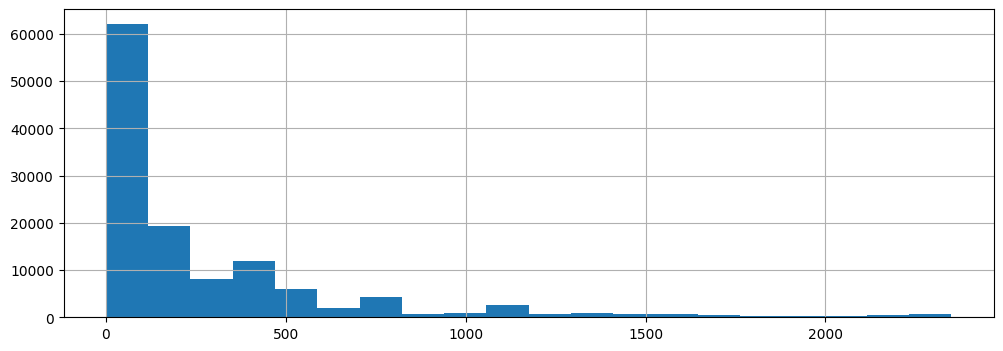

In [22]:
df[df.revenue<=df.revenue.quantile(0.95)].revenue.hist(bins=20, figsize=(12,4));

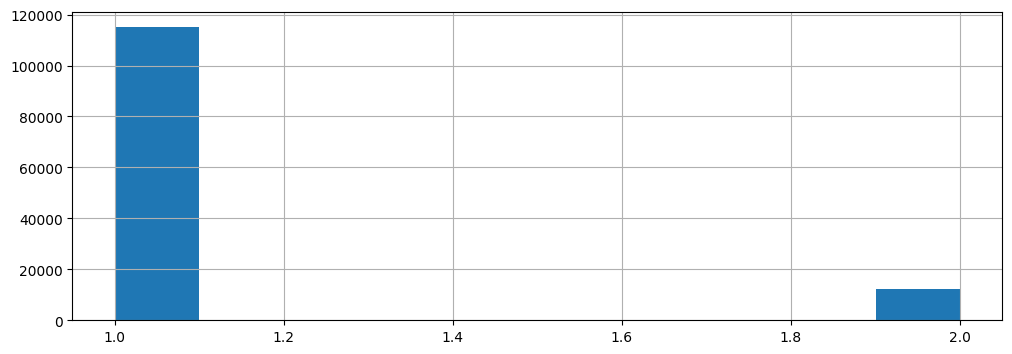

In [24]:
df[df.number_ads<=df.number_ads.quantile(0.95)].number_ads.hist(figsize=(12,4));

In [73]:
features_distribution = pd.DataFrame()
for col in ['region', 'platform', 'user_type_cars_name', 'vas']:
    features_distribution_ = df[col].value_counts(normalize=True).reset_index().rename(columns={col:'values', 'proportion': 'population_proportion'}).assign(columns = col)\
                                  .merge(df[col].value_counts().reset_index().rename(columns={col:'values', 'count': 'population_count'}), on='values')
    features_distribution = pd.concat([features_distribution, features_distribution_]).reset_index(drop=True)

features_distribution = features_distribution[['columns', 'values', 'population_count', 'population_proportion']]
features_distribution

,columns,values,population_count,population_proportion
0,region,Москва,32083,0.246580
1,region,Санкт-Петербург,15551,0.119520
2,region,Новосибирск,13965,0.107331
3,region,Сочи,11382,0.087478
4,region,Екатеринбург,7196,0.055306
5,region,Нижний Новгород,6344,0.048758
6,region,Челябинск,4880,0.037506
7,region,Самара,4803,0.036914
8,region,Казань,4481,0.034440
9,region,Ростов-на-Дону,4192,0.032218


### Стратификация с помощью pd.sample()

In [33]:
np.random.seed(42)
strat_sample_dataset = df.groupby(['region', 'platform', 'user_type_cars_name', 'vas'], group_keys = False).apply(lambda x: x.sample(frac=0.05))
print('Размер стратифицированной выборки =', len(strat_sample_dataset))

Размер стратифицированной выборки = 6478


<ipython-input-33-30e2655996f3>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strat_sample_dataset = df.groupby(['region', 'platform', 'user_type_cars_name', 'vas'], group_keys = False).apply(lambda x: x.sample(frac=0.05))


Посмотрим на сколько распределение признаков в стратифицированной выборке отличается от распределения признаков в исходных данных.

Можно сказать, что разница не особо критичная, хотя для некоторых узкопредставленных признаков может быть довольно существенной (mobile и cars_dealer)

In [75]:
features_distribution_ = pd.DataFrame()
for col in ['region', 'platform', 'user_type_cars_name', 'vas']:
    features_distribution_ = pd.concat([features_distribution_, strat_sample_dataset[col].value_counts(normalize=True).reset_index().rename(columns={col:'values', 'proportion': 'strat_sampe_proportion'}).assign(columns = col)]).reset_index(drop=True)

features_distribution = features_distribution.merge(features_distribution_, on=['columns','values'], how='left').fillna(0).assign(diff = lambda df: (df.strat_sampe_proportion-df.population_proportion)/df.population_proportion)
features_distribution

,columns,values,population_count,population_proportion,strat_sampe_proportion,diff
0,region,Москва,32083,0.246580,0.247453,0.003541
1,region,Санкт-Петербург,15551,0.119520,0.119636,0.000967
2,region,Новосибирск,13965,0.107331,0.107595,0.002463
3,region,Сочи,11382,0.087478,0.087373,-0.001210
4,region,Екатеринбург,7196,0.055306,0.055264,-0.000764
5,region,Нижний Новгород,6344,0.048758,0.048935,0.003627
6,region,Челябинск,4880,0.037506,0.037203,-0.008087
7,region,Самара,4803,0.036914,0.036894,-0.000549
8,region,Казань,4481,0.034440,0.034733,0.008519
9,region,Ростов-на-Дону,4192,0.032218,0.031646,-0.017779


In [82]:
features_distribution['diff'].describe()

,diff
count,30.000000
mean,-0.036637
std,0.119664
min,-0.594238
25%,-0.012826
50%,-0.001155
75%,0.002391
max,0.011392


## Стратификация с помощью взвешивания комбинации параметров

Этот способ явно проигрывает предыдущему - разница в распределении всех признаков довольно существенная, хотя трудоемкость генерации больше

In [86]:
df['combined'] = list(zip(df['region'], df['platform'], df['user_type_cars_name'], df['vas'])) # формируем столбец с комбинацией целевых параметров
weight = df['combined'].value_counts(normalize=True)
df['combined_weight'] = df['combined'].apply(lambda x: weight[x]) # рассчитываем вес каждой комбинации по которому будет сэплироваться выборка
df

,passport_id,region,platform,user_type_cars_name,number_ads,revenue,vas,combined,combined_weight
0,144161634,Санкт-Петербург,android,cars_seller,2,1080,1,"(Санкт-Петербург, android, cars_seller, 1)",0.003259
1,132683716,Калининград,android,cars_simple,1,190,1,"(Калининград, android, cars_simple, 1)",0.004827
2,142653188,Санкт-Петербург,android,cars_seller,1,0,0,"(Санкт-Петербург, android, cars_seller, 0)",0.000907
3,124199631,Казань,android,cars_simple,1,190,1,"(Казань, android, cars_simple, 1)",0.012543
4,144045240,Казань,android,cars_simple,1,0,0,"(Казань, android, cars_simple, 0)",0.010376
...,...,...,...,...,...,...,...,...,...
130107,144374570,Москва,android,cars_simple,2,1080,1,"(Москва, android, cars_simple, 1)",0.062930
130108,144245434,Омск,android,cars_simple,1,190,1,"(Омск, android, cars_simple, 1)",0.008516
130109,134759767,Самара,ios,cars_simple,1,580,1,"(Самара, ios, cars_simple, 1)",0.003820
130110,123856725,Москва,ios,cars_simple,2,0,0,"(Москва, ios, cars_simple, 0)",0.039312


In [91]:
# сэмплируем по весам комбинации параметров
strat_sample_dataset_2 = df.sample(len(strat_sample_dataset), weights=df['combined_weight']).drop(['combined','combined_weight'], axis=1).reset_index(drop=True)
strat_sample_dataset_2

,passport_id,region,platform,user_type_cars_name,number_ads,revenue,vas
0,138169847,Москва,ios,cars_simple,1,0,0
1,135728803,Москва,android,cars_simple,1,210,1
2,136974797,Самара,android,cars_simple,2,0,0
3,124248111,Санкт-Петербург,ios,cars_simple,1,210,1
4,143902176,Москва,android,cars_simple,1,590,1
...,...,...,...,...,...,...,...
6473,136284593,Москва,ios,cars_simple,1,0,0
6474,140251073,Санкт-Петербург,android,cars_simple,1,835,1
6475,139880092,Сочи,ios,cars_simple,1,190,1
6476,134679857,Москва,android,cars_simple,2,0,0


In [92]:
features_distribution_ = pd.DataFrame()
for col in ['region', 'platform', 'user_type_cars_name', 'vas']:
    features_distribution_ = pd.concat([features_distribution_, strat_sample_dataset_2[col].value_counts(normalize=True).reset_index().rename(columns={col:'values', 'proportion': 'strat_sampe_proportion_2'}).assign(columns = col)]).reset_index(drop=True)

features_distribution = features_distribution.merge(features_distribution_, on=['columns','values'], how='left').fillna(0).assign(diff_2 = lambda df: (df.strat_sampe_proportion_2-df.population_proportion)/df.population_proportion)
features_distribution

,columns,values,population_count,population_proportion,strat_sampe_proportion,diff,strat_sampe_proportion_2,diff_2
0,region,Москва,32083,0.246580,0.247453,0.003541,0.491201,0.992056
1,region,Санкт-Петербург,15551,0.119520,0.119636,0.000967,0.133683,0.118500
2,region,Новосибирск,13965,0.107331,0.107595,0.002463,0.144489,0.346205
3,region,Сочи,11382,0.087478,0.087373,-0.001210,0.077339,-0.115912
4,region,Екатеринбург,7196,0.055306,0.055264,-0.000764,0.027786,-0.497591
5,region,Нижний Новгород,6344,0.048758,0.048935,0.003627,0.026088,-0.464943
6,region,Челябинск,4880,0.037506,0.037203,-0.008087,0.010651,-0.716008
7,region,Самара,4803,0.036914,0.036894,-0.000549,0.019296,-0.477274
8,region,Казань,4481,0.034440,0.034733,0.008519,0.014048,-0.592110
9,region,Ростов-на-Дону,4192,0.032218,0.031646,-0.017779,0.009880,-0.693356


In [94]:
features_distribution[['diff', 'diff_2']].describe().T

,count,mean,std,min,25%,50%,75%,max
diff,30.0,-0.036637,0.119664,-0.594238,-0.012826,-0.001155,0.002391,0.011392
diff_2,30.0,-0.489149,0.484525,-1.000000,-0.839874,-0.697481,-0.146365,0.992056


In [103]:
features_distribution = features_distribution.drop(['strat_sampe_proportion_2','diff_2'], axis=1)

# Проверка выборки на репрезентативность

Воспользуемся для проверки на репрезентативность статистическим критерием, а именно - z-тестом для пропорций из библиотеки statsmodels

Полученный результат показывает, что по всем значениям признаков, кроме user_type_cars_name	= "cars_dealer" выборка, полученная первым способом репрезентативна

In [108]:
# Напишем функцию для проверки гипотезы
def sample_representativity_ztest_check (main_df, sample_df, parameter, value, is_print=True):
    '''проверка стратифицированной выборки на репрезентативность по выбранному параметру
    main_df - генеральная совокупность
    sample_df - выборка
    parameter - проверяемый параметр
    значение проверяемого параметра  для z-test
    '''
    count = np.array([len(sample_df[sample_df[parameter] == value]), len(main_df[main_df[parameter] == value])])
    nobs = np.array([len(sample_df), len(main_df)])
    stat, pval = proportions_ztest(count, nobs)
    if is_print:
        if pval < 0.05:
          print(f'p-value = {pval:.3f}, выборка по выбранному значению параметра {parameter} не репрезентативна')
        else:
          print(f'p-value = {pval:.3f}, выборка по выбранному значению параметра {parameter} репрезентативна')

    return pval

In [121]:
# Пример работы функции
sample_representativity_ztest_check(df, strat_sample_dataset, 'platform', 'android')

p-value = 0.836, выборка по выбранному значению параметра platform репрезентативна


np.float64(0.8358080706937163)

In [120]:
# Прогоним все значения параметров и проверим гипотезу о значимом отклонении пропорции при разбиении по этому признаку
pval_list = []
for parameter_, value_ in zip(features_distribution['columns'], features_distribution['values']):
    pval = sample_representativity_ztest_check(df, strat_sample_dataset, parameter_, value_, False)
    pval_list.append(pval)

features_distribution['p_value'] = pval_list
features_distribution

,columns,values,population_count,population_proportion,strat_sampe_proportion,diff,p_value
0,region,Москва,32083,0.246580,0.247453,0.003541,0.873586
1,region,Санкт-Петербург,15551,0.119520,0.119636,0.000967,0.977671
2,region,Новосибирск,13965,0.107331,0.107595,0.002463,0.946519
3,region,Сочи,11382,0.087478,0.087373,-0.001210,0.976525
4,region,Екатеринбург,7196,0.055306,0.055264,-0.000764,0.988421
5,region,Нижний Новгород,6344,0.048758,0.048935,0.003627,0.948567
6,region,Челябинск,4880,0.037506,0.037203,-0.008087,0.900187
7,region,Самара,4803,0.036914,0.036894,-0.000549,0.993269
8,region,Казань,4481,0.034440,0.034733,0.008519,0.899449
9,region,Ростов-на-Дону,4192,0.032218,0.031646,-0.017779,0.798773


# Проверка на SRM

Теперь мы имеем данные, уже распределенные на контрольную (А) и тестовую группы (B). Дизайном эксперимента предполагается, что группы представлены в равных пропорциях.

##  С помощью критерия chi-квадрат

In [5]:
df_2 = pd.read_csv('data_for_sample_2.csv')
df_2

,Unnamed: 0,passport_id,region,platform,user_type_cars_name,number_ads,revenue,vas,combined,combined_weight,group
0,105602,136957831,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']
1,46619,142530464,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['B']
2,97503,143220356,Волгоград,android,cars_seller,2,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['B']
3,35633,137497307,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']
4,52222,131622431,Волгоград,android,cars_seller,1,0,0,"('Волгоград', 'android', 'cars_seller', 0)",0.000007,['A']
...,...,...,...,...,...,...,...,...,...,...,...
26013,115718,137800551,Челябинск,ios,cars_simple,1,715,1,"('Челябинск', 'ios', 'cars_simple', 1)",0.000007,['A']
26014,49803,132964441,Челябинск,ios,cars_simple,1,1365,1,"('Челябинск', 'ios', 'cars_simple', 1)",0.000007,['B']
26015,6330,142012244,Челябинск,ios,cars_simple,1,190,1,"('Челябинск', 'ios', 'cars_simple', 1)",0.000007,['A']
26016,70319,143397390,Челябинск,ios,cars_simple,1,360,1,"('Челябинск', 'ios', 'cars_simple', 1)",0.000007,['B']


In [130]:
df_2['group'].value_counts()

,count
group,
['B'],14270
['A'],11748


In [129]:
pvalue = ss.chisquare(f_obs = [(df_2['group']=="['A']").sum(), (df_2['group']!="['A']").sum()],
                      f_exp = [len(df_2)/2, len(df_2)/2])[1]
alpha = 0.05
if pvalue < alpha:
    print(f'p-value = {pvalue:.3f}, SRM присутствует')
else:
    print(f'p-value = {pvalue:.3f}, SRM отсутствует')

p-value = 0.000, SRM присутствует


## С помощью последовательного тестирования SSRM

Зная, что выборки инкрементируются и сохраняются в хронологическом порядке, определим - начиная с какого наблюдения будет отклонена гипотеза об отсутствии SRM. Уровень значимости возьмем 0.05

Проверка показала, что гипотеза об отсутствии SRM будет отвергнута после 3023 пользователя

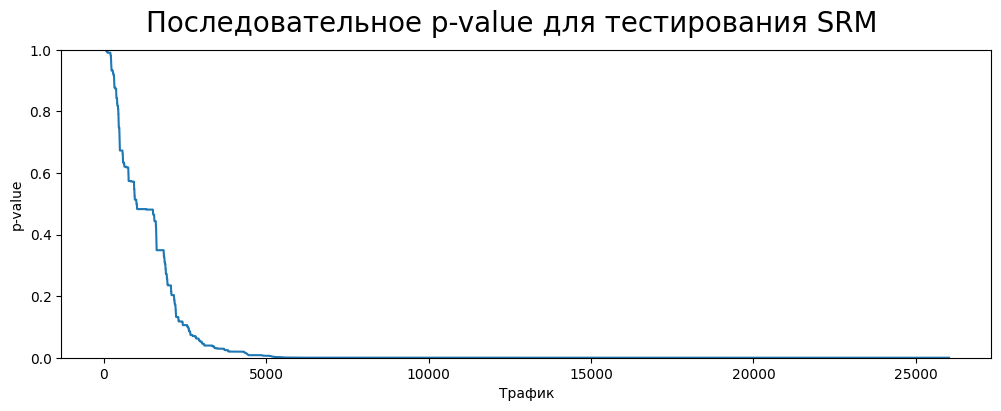

CPU times: user 2.95 s, sys: 113 ms, total: 3.06 s
Wall time: 3.02 s


In [14]:
%%time
# Закодируем принадлежность к группе в бинарный признак и сохраним в 2-х мерный массив
data = pd.DataFrame({'A':((df_2.group=="['A']")*1).values, 'B':((df_2.group=="['B']")*1).values}).values

pvals = ssrm_test.sequential_p_values(data, [0.5, 0.5])
fig = plt.figure(figsize=(12, 4))
plt.plot(pvals)
fig.suptitle("Последовательное p-value для тестирования SRM", fontsize=20)
plt.xlabel("Трафик")
plt.ylabel("p-value")
plt.ylim(0, 1)
plt.show()

In [10]:
sig_reached = np.argmax(np.array(pvals) < 0.05)
print(f"SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после {sig_reached} пользователей")
print(f"Это {sig_reached / len(df_2):.0%} от общего числа пользователей для этого эксперимента")

SSRM отклонило нулевую гипотезу об отсутствии SRM при уровне значимости alpha=0.05 после 3023 пользователей
Это 12% от общего числа пользователей для этого эксперимента


In [17]:
df_2[:3023]['group'].value_counts()

,count
group,
['B'],1654
['A'],1369
